# Quantum Convolutional Neural Network Classifier

Code at: [https://github.com/qiboteam/qibo/tree/master/examples/qcnn_classifier](https://github.com/qiboteam/qibo/tree/master/examples/qcnn_classifier).
Please note that [scikit-learn](https://scikit-learn.org/stable/install.html) is needed to visualize the results.

## Problem overview
This tutorial implements a simple [Quantum Convolutional Neural Network](https://www.nature.com/articles/s41567-019-0648-8) (QCNN), which is a translationally invariant algorithm analogous to the classical [convolutional neural network](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). This example demonstrates the use of the QCNN as a quantum classifier, which attempts to classify ground states of a translationally invariant quantum system, the transverse field Ising model, based on whether they are in the ordered or disordered phase. The (randomized) statevector data provided are those of a 4-qubit system. Accompanying each state is a label: +1 (disordered phase) or -1 (ordered phase).

Through the sequential reduction of entanglement, this network is able to perform classification from the final measurement of a single qubit.

Workflow of QCNN model:
![workflow](images/workflow.PNG)

Schematic of QCNN model:
![schematic](images/structure.PNG)

Convolutional layer for 4 qubits as an example:
![convolution](images/convolution_4qubits.PNG)

Pooling layer for 4 qubits as an example:
![pooling](images/pooling_4qubits.PNG)

where in the above, $R(\theta_{i,j,k}) = RZ(\theta_k) RY(\theta_j) RX(\theta_i)$:
![R](images/RxRyRz.PNG)

$U_{q_a, q_b}(\theta_{i,j,k}) = RXX(\theta_k) RYY(\theta_j) RZZ(\theta_i)$ is a two-qubit gate acting on qubits $q_a$ and $q_b$:
![U](images/U.PNG)

and $R^{\dagger}(\theta_{i,j,k}) = RX(-\theta_i) RY(-\theta_j) RZ(-\theta_k)$:
![RT](images/RT.PNG)


## How to use the QCNN class
For more details on the QuantumCNN class, please refer to the documentation. Here we recall some of the necessary arguments when instantiating a QuantumCNN object:
- `nqubits` (int): number of quantum bits. It should be larger than 2 for the model to make sense.
- `nlayers` (int): number of layers of the QCNN variational ansatz.
- `nclasses` (int): number of classes of the training set (default=2).
- `params`: list to initialise the variational parameters (default=None).

After creating the object, one can proceed to train the model. For this, the `QuantumCNN.minimize` method can be used with the following arguments (refer to the documentation for more details)"
- `init_theta`: list or numpy.array with the angles to be used in the circuit
- `data`: the training data
- `labels`: numpy.array containing the labels for the training data
- `nshots` (int):number of runs of the circuit during the sampling process (default=10000)
- `method` (string): str 'classical optimizer for the minimization'. All methods from scipy.optimize.minmize are suported (default='Powell').

## QCNN Demo

Include necessary packages:

In [4]:
import numpy as np
import random
from sklearn import metrics

import qibo
from qibo.models.qcnn import QuantumCNN

qibo.set_backend("numpy")

[Qibo 0.1.13|INFO|2023-05-15 17:25:59]: Using numpy backend on /CPU:0


Load the provided data (ground states of 4-qubit TFIM in data folder) and labels:

In [5]:
data = np.load('nqubits_4_data_shuffled_no0.npy')
labels = np.load('nqubits_4_labels_shuffled_no0.npy')
labels = np.transpose(np.array([labels])) # restructure to required array format

Structure of data and labels are like:

In [6]:
data[-2:]

array([[0.52745364+0.j, 0.19856967+0.j, 0.19856967+0.j, 0.16507377+0.j,
        0.19856967+0.j, 0.09784837+0.j, 0.16507377+0.j, 0.19856967+0.j,
        0.19856967+0.j, 0.16507377+0.j, 0.09784837+0.j, 0.19856967+0.j,
        0.16507377+0.j, 0.19856967+0.j, 0.19856967+0.j, 0.52745364+0.j],
       [0.67109214+0.j, 0.10384038+0.j, 0.10384038+0.j, 0.05351362+0.j,
        0.10384038+0.j, 0.02786792+0.j, 0.05351362+0.j, 0.10384038+0.j,
        0.10384038+0.j, 0.05351362+0.j, 0.02786792+0.j, 0.10384038+0.j,
        0.05351362+0.j, 0.10384038+0.j, 0.10384038+0.j, 0.67109214+0.j]])

In [7]:
labels[-2:]

array([[ 1.],
       [-1.]])

Split the data into training/test set in the ratio 60:40

In [8]:
split_ind = int(len(data) * 0.6)
train_data = data[:split_ind]
test_data = data[split_ind:]

train_labels = labels[:split_ind]
test_labels = labels[split_ind:]

Initialize the QuantumCNN class:

In [9]:
test = QuantumCNN(nqubits=4, nlayers=1, nclasses=2)
testcircuit = test._circuit
print(testcircuit.draw())

q0:     ─RX─RY─RZ─RZZ─RYY─RXX─RX─RY─RZ──────────────────────────────────────── ...
q1:     ─RX─RY─RZ─RZZ─RYY─RXX─RX─RY─RZ─────────────RX─RY─RZ──────────RZZ─RYY─R ...
q2:     ──────────────────────RX─RY─RZ─RZZ─RYY─RXX─RX─RY─RZ─RX─RY─RZ─RZZ─RYY─R ...
q3:     ──────────────────────RX─RY─RZ─RZZ─RYY─RXX─RX─RY─RZ─────────────────── ...

q0: ... ───RX─RY─RZ─RZZ─RYY─RXX─RX─RY─RZ─RX─RY─RZ─o───────────────────────
q1: ... XX─RX─RY─RZ─|───|───|─────────────────────|─RX─RY─RZ─o────────────
q2: ... XX─RX─RY─RZ─|───|───|───RX─RY─RZ──────────X─RZ─RY─RX─|────────────
q3: ... ───RX─RY─RZ─RZZ─RYY─RXX─RX─RY─RZ────────────RX─RY─RZ─X─RZ─RY─RX─M─


draw() is used to visualize the pre-constructed circuit based on input parameters for class initialization.

Initialize model parameters:

In [10]:
testbias = np.zeros(test.measured_qubits)
testangles = [random.uniform(0,2*np.pi) for i in range(21*2)]
init_theta = np.concatenate((testbias, testangles))

Train model with optimize parameters (automatically updates model with optimized paramters at the end of training):

In [ ]:
result = test.minimize(init_theta, data=train_data, labels=labels, nshots=10000, method='Powell')

Alternatively, update model with optimized parameters from previous training:

In [11]:
saved_result_60 = (0.2026119742575817, np.array([ -0.06559061,   3.62881221,   2.39850148,   3.02493711,
         0.91498683,   3.25517842,   0.0759049 ,   3.46049453,
         3.04395784,   1.55681424,   2.3665245 ,   0.40291846,
         5.67310744,   2.27615444,   5.23403537,   0.46053411,
         0.69228362,   2.2308165 ,   0.53323661,   4.52157388,
         5.31194656,  18.23511858,  -1.90754635,  14.30577217,
        10.75135972,  19.16001316,  12.27582746,   7.47476354,
        23.38129141,  60.29771502,  10.02946377,  17.83945879,
        15.22732248,  12.34666584,   1.52634649,   1.90621517,
        12.71554053, -13.56379057,  34.04591253, -11.56450878,
        10.95038782,   3.30640208,   9.67270071]))

test.set_circuit_params(angles=saved_result_60[1], has_bias=True)

Generate predictions from optimized model:

In [12]:
predictions = []
for n in range(len(test_data)):
    predictions.append(test.predict(test_data[n], nshots=10000)[0])

Visualize results via confusion matrix and accuracy:

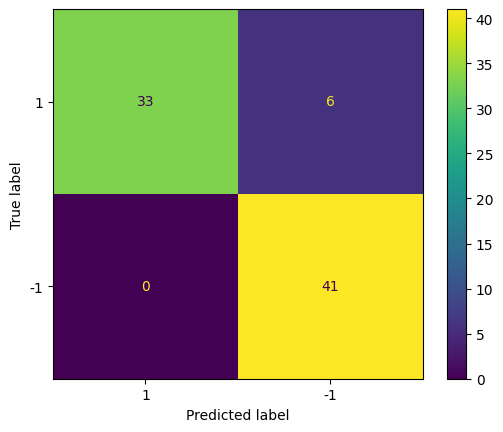

In [14]:
actual = [np.sign(test_labels) for test_labels in test_labels]
predicted = [np.sign(prediction) for prediction in predictions]

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, -1])

cm_display.plot()

In [15]:
test.Accuracy(test_labels,predictions)

0.925